<a href="https://colab.research.google.com/github/jadhav-rakesh/Time_Series_Forecasting/blob/main/time_series_forecast_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size, drop_remainder=True).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

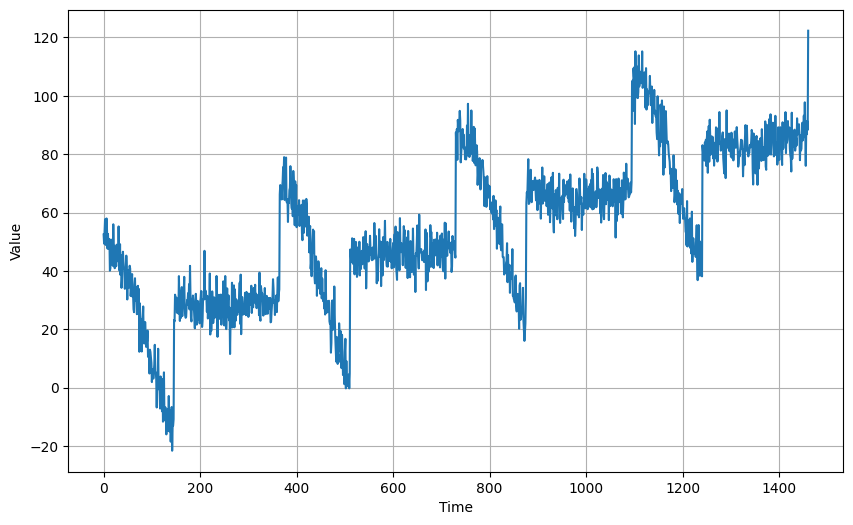

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/ 20)
)

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 32.5248 - mae: 32.5012 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 33.6689 - mae: 33.6420 - learning_rate: 1.1220e-08
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 32.6147 - mae: 32.5969 - learning_rate: 1.2589e-08
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 32.4602 - mae: 32.4469 - learning_rate: 1.4125e-08
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 31.7642 - mae: 31.7543 - learning_rate: 1.5849e-08
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 31.5781 - mae: 31.5737 - learning_rate: 1.7783e-08
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 31.2453 - mae: 31.2477 - learning_rate: 1.9953e-08
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 31.0694 - mae: 31.0784 - learning_rate: 2.2387e-08
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 30.5810 - mae: 30.5948 - learning_rate: 2.5119e-08
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 30.0613 - mae: 30.0837 - learning_rate: 2.8184e-08
Epoch 11/100
7/7 ━━━━━━━━━━━━━

(1e-07, 0.01, 0.0, 30.0)

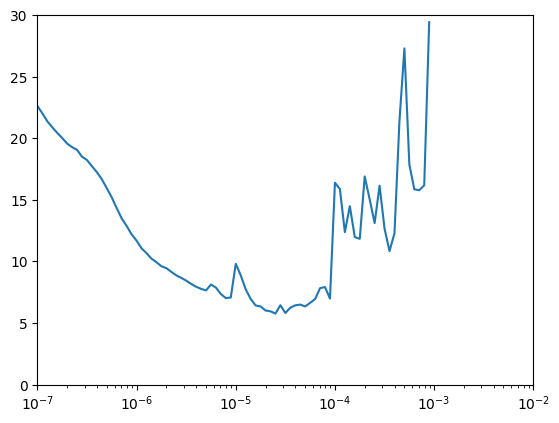

In [6]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-2, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping])

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 91.5001 - mae: 90.9019 - val_loss: 24.6962 - val_mae: 18.8936
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 40.8239 - mae: 40.7314 - val_loss: 36.7658 - val_mae: 27.9487
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 21.9221 - mae: 22.0872 - val_loss: 21.3813 - val_mae: 16.4062
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 17.9117 - mae: 18.1421 - val_loss: 36.0479 - val_mae: 27.4103
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 13.8945 - mae: 14.1706 - val_loss: 21.2243 - val_mae: 16.2902
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 11.2532 - mae: 11.5635 - val_loss: 19.2028 - val_mae: 14.7726
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 9.9294 - mae: 10.2582 - val_loss: 18.7014 - val_mae: 14.3976
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 9.1093 - mae: 9.4499 - val_loss: 15.6059 - val_mae: 12.0748
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6

In [8]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


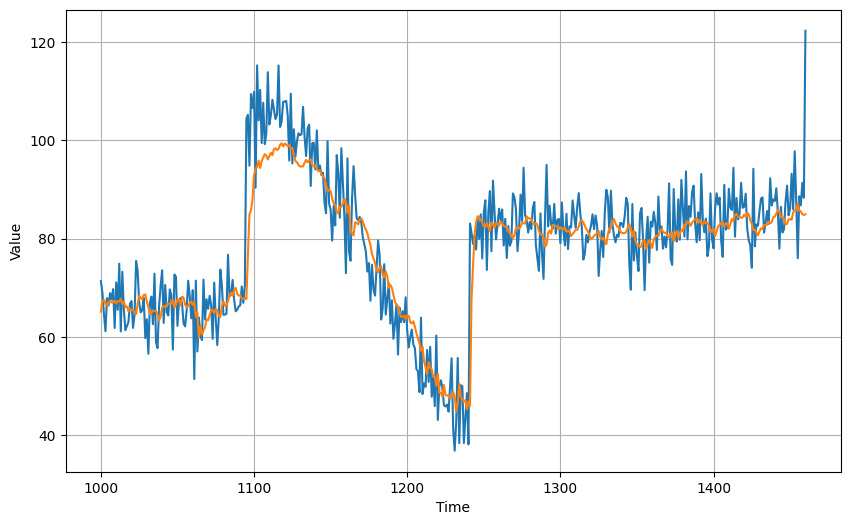

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
mae_metric = keras.metrics.MeanAbsoluteError()
mae_metric.reset_state()
mae_metric.update_state(x_valid, rnn_forecast)
mae = mae_metric.result().numpy()
mae

5.0381474

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64

train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32,
                            kernel_size=2,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding="causal",
                            activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-4 * 10**(epoch / 30)
)

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 42.2535 - mae: 42.0861 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 40.9916 - mae: 40.8431 - learning_rate: 1.0798e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 38.8814 - mae: 38.7580 - learning_rate: 1.1659e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 37.0984 - mae: 37.0297 - learning_rate: 1.2589e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 28.2355 - mae: 28.3398 - learning_rate: 1.3594e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 20.3963 - mae: 20.5724 - learning_rate: 1.4678e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 16.3448 - mae: 16.5767 - learning_rate: 1.5849e-04
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 13.6197 - mae: 13.8959 - learning_rate: 1.7113e-04
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 11.0662 - mae: 11.3803 - learning_rate: 1.8478e-04
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 8.6567 - mae: 9.0041 - learning_rate: 1.9953e-04
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━

(0.0001, 0.1, 0.0, 30.0)

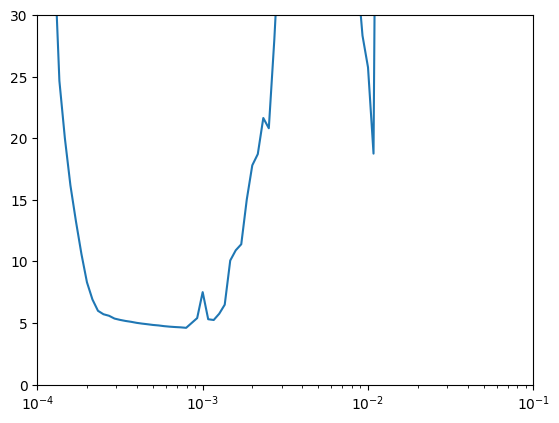

In [14]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64

train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32,
                            kernel_size=2,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding="causal",
                            activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


      6/Unknown 3s 48ms/step - loss: 41.9619 - mae: 42.4609

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 41.9449 - mae: 41.7815 - val_loss: 77.4941 - val_mae: 58.4956
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 41.0460 - mae: 40.8956 - val_loss: 75.2007 - val_mae: 56.7755
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 38.8814 - mae: 38.7626 - val_loss: 66.2526 - val_mae: 50.0645
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 31.0272 - mae: 31.1084 - val_loss: 41.2577 - val_mae: 31.3165
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 21.2091 - mae: 21.3979 - val_loss: 33.1389 - val_mae: 25.2292
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 14.8287 - mae: 15.1074 - val_loss: 19.5271 - val_mae: 15.0178
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 10.9365 - mae: 11.2554 - val_loss: 13.5981 - val_mae: 10.5666
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 8.7144 - mae: 9.0597 - val_loss: 10.9739 - val_mae: 8.5975
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/st

In [18]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


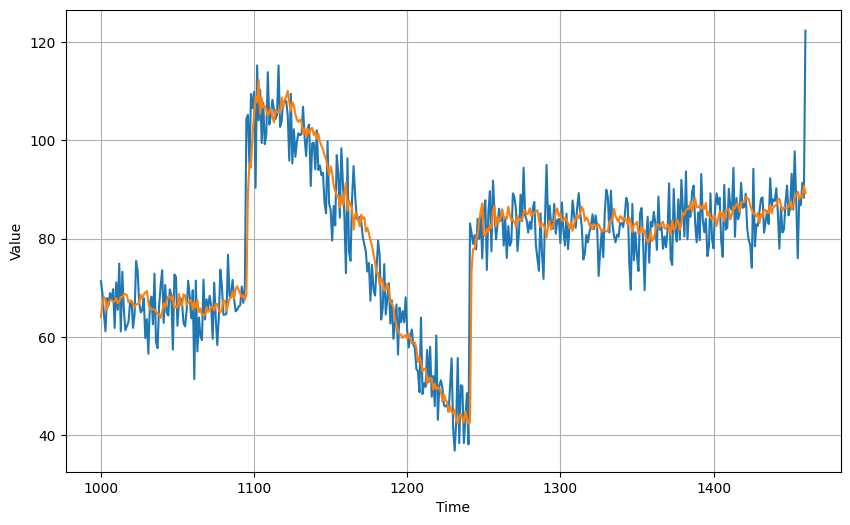

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [20]:
mae_metric.reset_state()
mae_metric.update_state(x_valid, cnn_forecast)
mae = mae_metric.result().numpy()
mae

4.676392